In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict

Load dataset

In [2]:
df = pd.read_csv("groceries_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])  

df.head()

C:\Users\China\AppData\Local\Temp\ipykernel_20716\2823225029.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-01-05,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-02-01,whole milk


In [3]:
transactions = df.groupby('Member_number')['itemDescription'].apply(list).tolist()

if len(transactions) < 100:
    transactions = transactions[:100]  

item_counts = defaultdict(int)
for transaction in transactions:
    for item in transaction:
        item_counts[item] += 1

print("Item Counts (Top 10):", sorted(item_counts.items(), key=lambda x: x[1], reverse=True)[:10])

Item Counts (Top 10): [('whole milk', 2502), ('other vegetables', 1898), ('rolls/buns', 1716), ('soda', 1514), ('yogurt', 1334), ('root vegetables', 1071), ('tropical fruit', 1032), ('bottled water', 933), ('sausage', 924), ('citrus fruit', 812)]


Implement the Apriori Algorithm

In [4]:
def get_frequent_itemsets(transactions, min_support):
    item_counts = defaultdict(int)
    
    for transaction in transactions:
        for item in transaction:
            item_counts[item] += 1
            
    total_transactions = len(transactions)
    frequent_items = {item: count for item, count in item_counts.items() if count / total_transactions >= min_support}
    
    return frequent_items

def generate_candidates(prev_itemsets, k):
    candidates = []
    
    # Convert single-item strings to tuples
    prev_itemsets = [tuple([item]) if isinstance(item, str) else item for item in prev_itemsets]
    
    for a, b in itertools.combinations(prev_itemsets, 2):
        merged = tuple(sorted(set(a + b)))  
        if len(merged) == k:
            candidates.append(merged)

    print(f"Generated Candidates at Step {k}: {candidates}")  
    return list(set(candidates))

def apriori(transactions, min_support):
    frequent_itemsets = []
    one_itemsets = get_frequent_itemsets(transactions, min_support)
    current_itemsets = list(one_itemsets.keys())

    k = 2
    while current_itemsets:
        print(f"Previous Itemsets at Step {k-1}: {current_itemsets}")
        candidates = generate_candidates(current_itemsets, k)

        item_counts = defaultdict(int)
        for transaction in transactions:
            for candidate in candidates:
                if set(candidate).issubset(transaction):
                    item_counts[candidate] += 1

        # Print support values before filtering
        for itemset, count in item_counts.items():
            print(f"Itemset {itemset}: Support {count / len(transactions):.5f}")

        current_itemsets = [item for item, count in item_counts.items() if count / len(transactions) >= min_support]

        frequent_itemsets.extend(current_itemsets)
        k += 1

    return frequent_itemsets

frequent_itemsets = apriori(transactions, min_support=0.1)
print("Frequent Itemsets:", frequent_itemsets)

Previous Itemsets at Step 1: ['soda', 'canned beer', 'sausage', 'whole milk', 'yogurt', 'pastry', 'frankfurter', 'beef', 'curd', 'whipped/sour cream', 'rolls/buns', 'tropical fruit', 'butter', 'frozen vegetables', 'other vegetables', 'root vegetables', 'pip fruit', 'shopping bags', 'margarine', 'chicken', 'bottled water', 'bottled beer', 'domestic eggs', 'newspapers', 'coffee', 'citrus fruit', 'brown bread', 'fruit/vegetable juice', 'pork']
Generated Candidates at Step 2: [('canned beer', 'soda'), ('sausage', 'soda'), ('soda', 'whole milk'), ('soda', 'yogurt'), ('pastry', 'soda'), ('frankfurter', 'soda'), ('beef', 'soda'), ('curd', 'soda'), ('soda', 'whipped/sour cream'), ('rolls/buns', 'soda'), ('soda', 'tropical fruit'), ('butter', 'soda'), ('frozen vegetables', 'soda'), ('other vegetables', 'soda'), ('root vegetables', 'soda'), ('pip fruit', 'soda'), ('shopping bags', 'soda'), ('margarine', 'soda'), ('chicken', 'soda'), ('bottled water', 'soda'), ('bottled beer', 'soda'), ('domestic

Extract Association Rules

In [5]:
def generate_association_rules(frequent_itemsets, transactions, min_confidence):
    rules = []
    for itemset in frequent_itemsets:
        if len(itemset) > 1:
            subsets = list(itertools.combinations(itemset, len(itemset) - 1))
            for subset in subsets:
                subset_support = sum(1 for t in transactions if set(subset).issubset(t)) / len(transactions)
                itemset_support = sum(1 for t in transactions if set(itemset).issubset(t)) / len(transactions)
                confidence = itemset_support / subset_support if subset_support > 0 else 0
                
                if confidence >= min_confidence:
                    rules.append((subset, set(itemset) - set(subset), confidence))

    return rules

association_rules = generate_association_rules(frequent_itemsets, transactions, min_confidence=0.5)
for rule in association_rules:
    print(f"Rule: {rule[0]} → {rule[1]}, Confidence: {rule[2]:.2f}")

Rule: ('yogurt',) → {'whole milk'}, Confidence: 0.53
Rule: ('sausage',) → {'whole milk'}, Confidence: 0.52
Rule: ('rolls/buns',) → {'whole milk'}, Confidence: 0.51
Rule: ('other vegetables',) → {'whole milk'}, Confidence: 0.51
Rule: ('bottled water',) → {'whole milk'}, Confidence: 0.53


Visualize the Frequent Itemsets

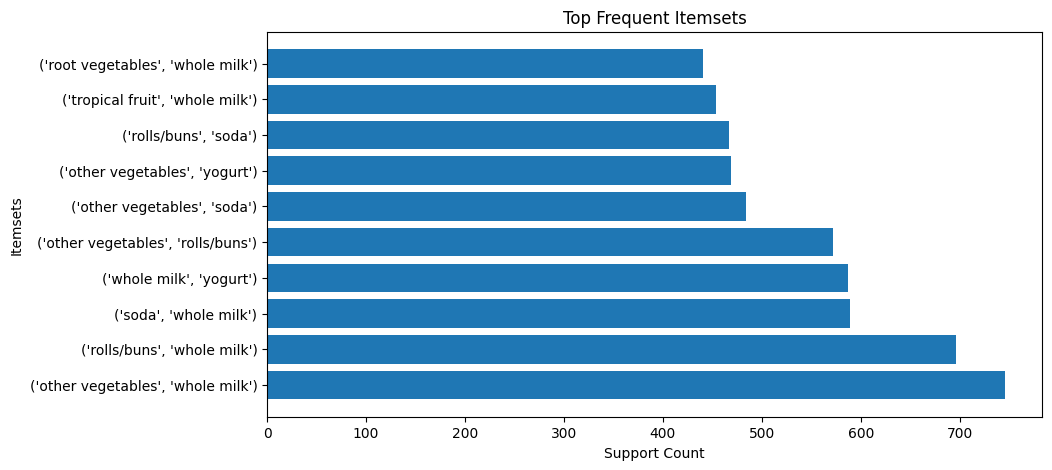

In [6]:
item_counts = {str(itemset): sum(1 for t in transactions if set(itemset).issubset(t)) for itemset in frequent_itemsets}
sorted_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 5))
plt.barh([item[0] for item in sorted_items[:10]], [item[1] for item in sorted_items[:10]])
plt.xlabel("Support Count")
plt.ylabel("Itemsets")
plt.title("Top Frequent Itemsets")
plt.show()